# ShapModel: Explaining with single-residue resolution

To enable explanations of sample-specific predictions at the single-residue level, we've developed a wrapper model around [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html). This explainable AI framework adopts a game-theoretic approach to elucidate the output of any machine learning model. Our ``ShapModel`` model, introduced in [Breimann25a]_, fits multiple SHAP explainers and integrates their output to provide a robust estimate of feature impacts.

## Obtaining Feature Impact
To illustrate, we'll use an example dataset comprising γ-secretase substrates (n=63) and non-substrates (n=63) from [Breimann25a]_. We'll explain the model's prediction output for the Alzheimer’s disease-associated amyloid precursor protein (APP): 

In [11]:
import aaanalysis as aa
aa.options["verbose"] = False
aa.options["random_state"] = 42

# Load dataset and respective features
df_seq = aa.load_dataset(name="DOM_GSEC")
labels = list(df_seq["label"])
df_feat = aa.load_features(name="DOM_GSEC")

# Show APP
aa.display_df(df=df_seq, n_rows=10, char_limit=25)

,entry,sequence,label,tmd_start,tmd_stop,jmd_n,tmd,jmd_c
1,P05067,MLPGLALLLLAA...NPTYKFFEQMQN,1,701,723,FAEDVGSNKG,AIIGLMVGGVVIATVIVITLVML,KKKQYTSIHH
2,P14925,MAGRARSGLLLL...YSAPLPKPAPSS,1,868,890,KLSTEPGSGV,SVVLITTLLVIPVLVLLAIVMFI,RWKKSRAFGD
3,P70180,MRSLLLFTFSAC...REDSIRSHFSVA,1,477,499,PCKSSGGLEE,SAVTGIVVGALLGAGLLMAFYFF,RKKYRITIER
4,Q03157,MGPTSPAARGQG...ENPTYRFLEERP,1,585,607,APSGTGVSRE,ALSGLLIMGAGGGSLIVLSLLLL,RKKKPYGTIS
5,Q06481,MAATGTAAAAAT...NPTYKYLEQMQI,1,694,716,LREDFSLSSS,ALIGLLVIAVAIATVIVISLVML,RKRQYGTISH
6,P35613,MAAALFVLLGFA...DKGKNVRQRNSS,1,323,345,IITLRVRSHL,AALWPFLGIVAEVLVLVTIIFIY,EKRRKPEDVL
7,P35070,MDRAARCSGASS...PINEDIEETNIA,1,119,141,LFYLRGDRGQ,ILVICLIAVMVVFIILVIGVCTC,CHPLRKRRKR
8,P09803,MGARCRSFSALL...KLADMYGGGEDD,1,711,733,GIVAAGLQVP,AILGILGGILALLILILLLLLFL,RRRTVVKEPL
9,P19022,MCRIAGALRTLL...KKLADMYGGGDD,1,724,746,RIVGAGLGTG,AIIAILLCIIILLILVLMFVVWM,KRRDKERQAK
10,P16070,MDKFWWHAAWGL...RNLQNVDMKIGV,1,650,672,GPIRTPQIPE,WLIILASLLALALILAVCIAVNS,RRRCGQKKKL


To fit the ``ShapModel``, we fist need to create the feature matrix using the ``SequenceFeature.feat_matrix()`` method:  

In [12]:
# Create feature matrix
sf = aa.SequenceFeature()
df_parts = sf.get_df_parts(df_seq=df_seq)
X = sf.feature_matrix(df_parts=df_parts, features=df_feat["feature"])

The difference of feature values between a selected protein (e.g., APP) and the reference dataset can be included into the feature DataFrame using the ``ShapModel.add_sample_mean_dif()`` method. This will create a new `mean_dif_'name'` column (e.g., 'mean_dif_APP'):

In [13]:
se = aa.ShapModel()
se.fit(X, labels=labels)

# Add the feature value difference for the first protein (APP)
df_feat = se.add_sample_mean_dif(X, labels=labels, df_feat=df_feat, 
                                 sample_positions=0, names="APP")

To add the sample-specific feature impact, use the ``ShapModel.add_feat_impact()`` method. This will create a new `feat_impact_'name'` column (e.g., 'feat_impact_APP'):

In [14]:
# Add feature impacts for the first protein (APP)
df_feat = se.add_feat_impact(df_feat=df_feat, sample_positions=0, names="APP")
aa.display_df(df=df_feat, n_rows=5)

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions,feat_importance,feat_importance_std,mean_dif_APP,feat_impact_APP
1,"TMD_C_JMD_C-Seg...3,4)-KLEP840101",Energy,Charge,Charge,"Net charge (Kle...n et al., 1984)",0.244000,0.103666,0.103666,0.106692,0.110506,0.000000,0.000000,"31,32,33,34,35",0.970400,1.438918,0.220635,0.980000
2,"TMD_C_JMD_C-Seg...3,4)-FINA910104",Conformation,α-helix (C-cap),α-helix termination,"Helix terminati...n et al., 1991)",0.243000,0.085064,0.085064,0.098774,0.096946,0.000000,0.000000,"31,32,33,34,35",0.000000,0.000000,0.193990,1.330000
3,"TMD_C_JMD_C-Seg...6,9)-LEVM760105",Shape,Side chain length,Side chain length,"Radius of gyrat... (Levitt, 1976)",0.233000,0.137044,0.137044,0.161683,0.176964,0.000000,0.000001,"32,33",1.554800,2.109848,0.283275,1.710000
4,"TMD_C_JMD_C-Seg...3,4)-HUTJ700102",Energy,Entropy,Entropy,"Absolute entrop...Hutchens, 1970)",0.229000,0.098224,0.098224,0.106865,0.124608,0.000000,0.000001,"31,32,33,34,35",3.111200,3.109955,0.162838,2.860000
5,"TMD_C_JMD_C-Seg...6,9)-RADA880106",ASA/Volume,Volume,Accessible surface area (ASA),"Accessible surf...olfenden, 1988)",0.223000,0.095071,0.095071,0.114758,0.132829,0.000000,0.000002,"32,33",0.000000,0.000000,0.189680,1.140000


## Visualizing Feature Impact

Features can have either a positive (red) or negative (blue) impact, indicating whether they increase or decrease the model's prediction output, respectively.
Before visualizing impact of features, we need to obtain its sequence parts:

In [15]:
import matplotlib.pyplot as plt

# Get sequences parts for APP
_df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd", "jmd_c", "jmd_n"])
_args_seq = _df_parts.loc["P05067"].to_dict()   # Accession number of APP
args_seq = {key + "_seq": _args_seq[key] for key in _args_seq}


To explain the feature impact with single-residue resolution, AAanalysis offers the following four types of visualizations: **CPP-SHAP ranking plot**, **CPP-SHAP profile**, **CPP heatmap**, **CPP-SHAP heatmap**. An overview is provided under [Explainable AI Usage Principles](https://aaanalysis.readthedocs.io/en/latest/index/usage_principles/xai.html)   

We can first show the feature ranking for a selected protein ('Protein0') using the ``CPPPlot.ranking()`` method, plotting SHAP analysis results by setting ``shap_plot=True``:

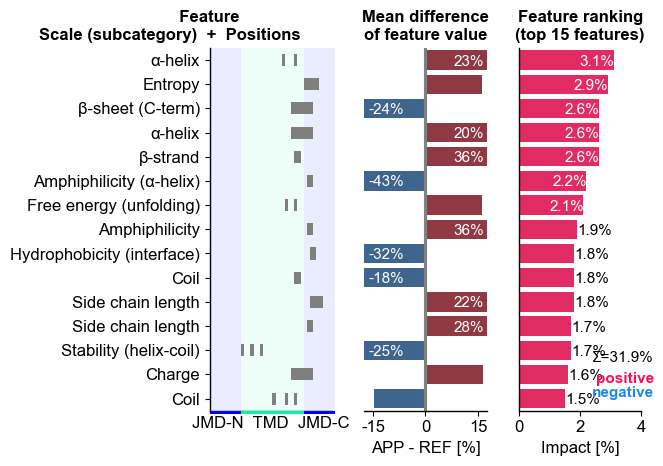

In [16]:
# CPP-SHAP ranking plot
cpp_plot = aa.CPPPlot()
aa.plot_settings(short_ticks=True, weight_bold=False)
cpp_plot.ranking(df_feat=df_feat, shap_plot=True, 
                 col_dif="mean_dif_APP", col_imp="feat_impact_APP",
                 name_test="APP")
plt.tight_layout()
plt.show()

Show the specific **CPP-SHAP Profile** for the first Protein using the ``CPPPlot.profile()`` method with setting ``shap_plot=True``:

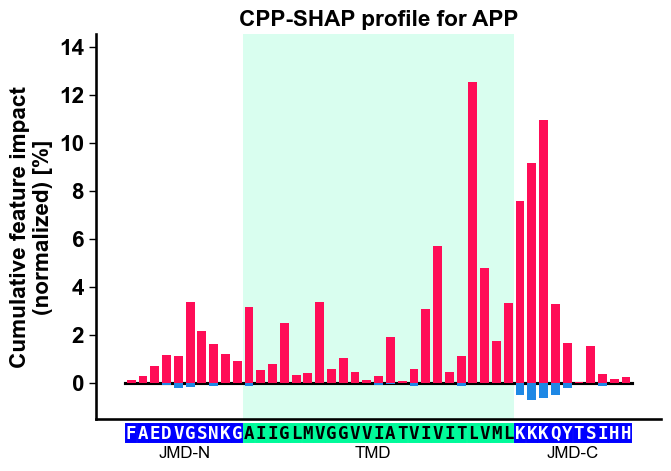

In [17]:
# CPP-SHAP profile
aa.plot_settings(font_scale=0.9)
cpp_plot.profile(df_feat=df_feat, shap_plot=True, 
                 col_imp="feat_impact_APP", **args_seq)
plt.title("CPP-SHAP profile for APP")
plt.tight_layout()
plt.show()

With the ``CPPPlot.heatmap()`` method we can visualize the sample-specific feature value difference and the feature impact per scale subcategory and residue position. Set ``shap_plot=True`` and provide the respective column with the mean difference and the feature impact:

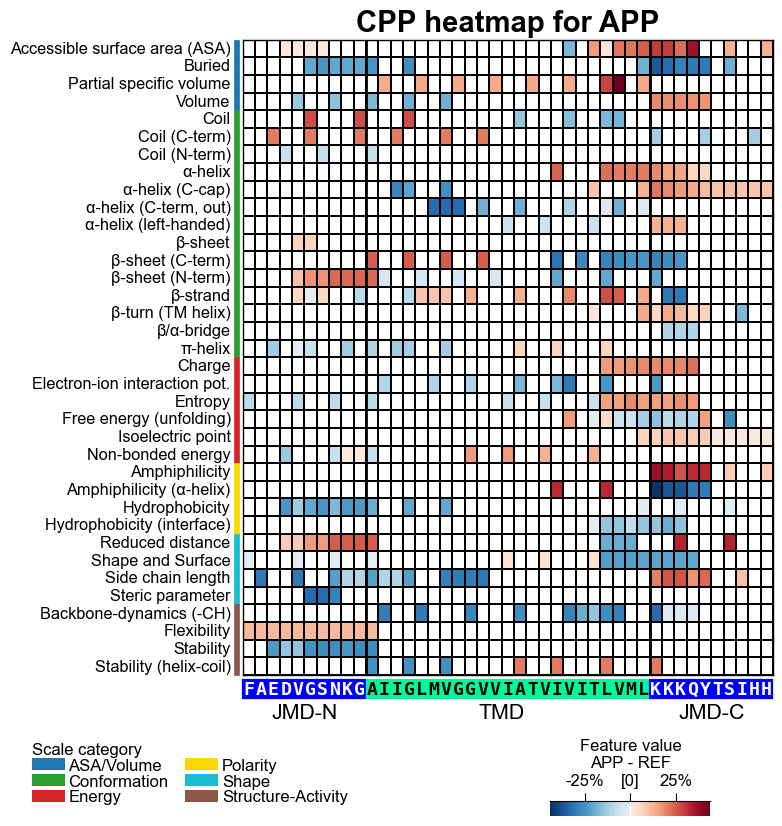

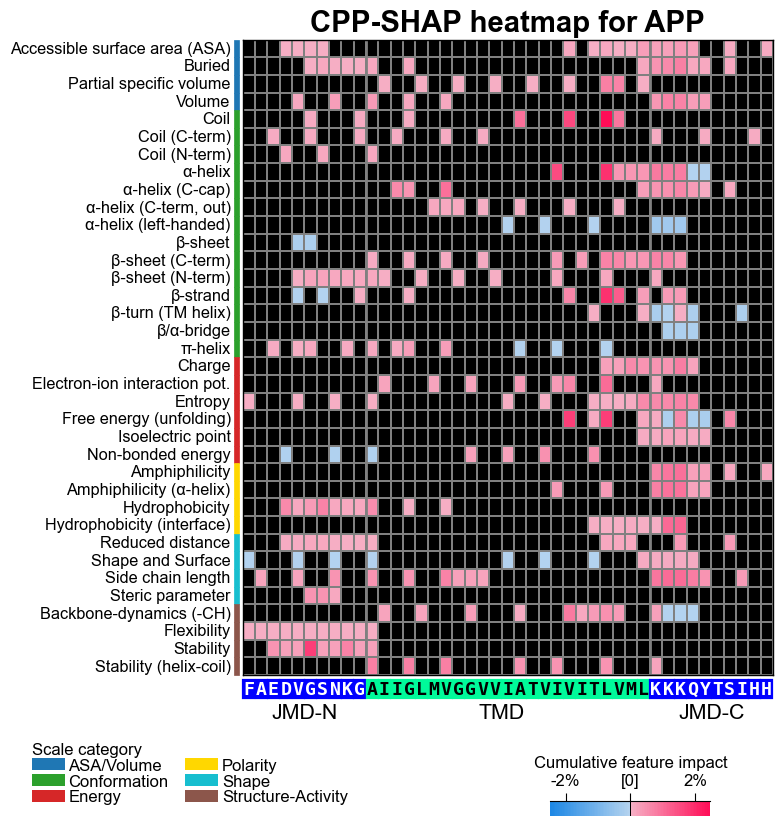

In [18]:
# CPP heatmap (sample level)
fs = aa.plot_gcfs()
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.heatmap(df_feat=df_feat, shap_plot=True,
                 col_val="mean_dif_APP", **args_seq, name_test="APP")
plt.title("CPP heatmap for APP", fontsize=fs+5, weight="bold")
plt.show()

# CPP-SHAP heatmap (sample level)
cpp_plot.heatmap(df_feat=df_feat, shap_plot=True, 
                 col_val="feat_impact_APP", **args_seq)
plt.title("CPP-SHAP heatmap for APP", fontsize=fs+5, weight="bold")
plt.show()

You can create as well the feature map for individual samples. We first have the convert the feature impact into feature importance by simply taking their absolute values.

In [19]:
# Add feature importance
df_feat.insert(len(df_feat.T), "feat_importance_APP", [abs(x) for x in df_feat["feat_impact_APP"]])

The feature map can be created using the ``CPPPlot.feature_map()`` method with providing the respective sequence parts and data columns:

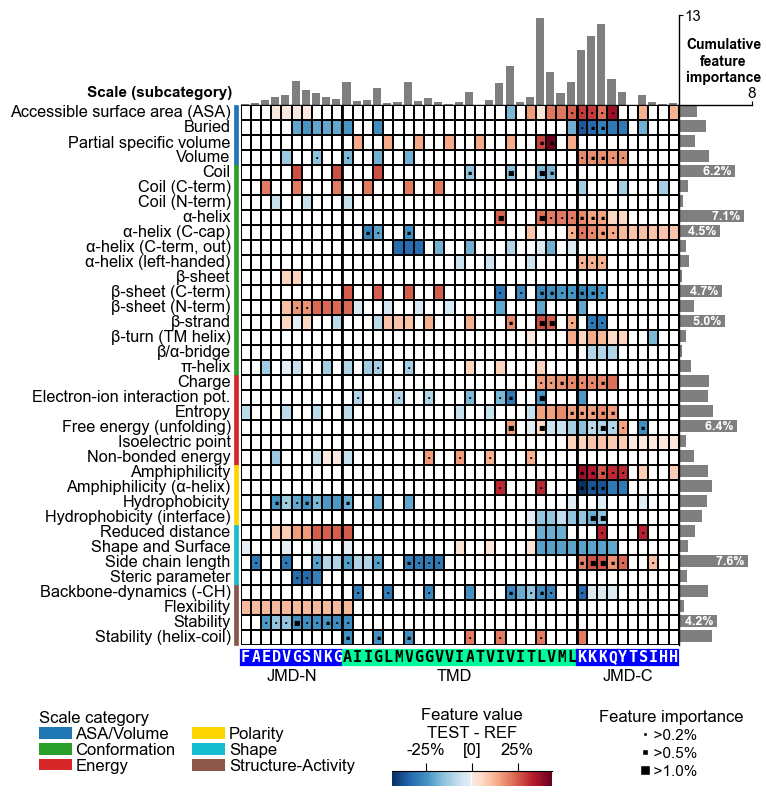

In [20]:
# CPP feature map (sample level)
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.feature_map(df_feat=df_feat, col_val="mean_dif_APP", col_imp="feat_importance_APP", **args_seq)
plt.show()

Details on the ``ShapModel`` class can be found in the [ShapModel API](https://aaanalysis.readthedocs.io/en/latest/generated/aaanalysis.ShapModel.html). More information on explainable AI and how CPP and SHAP were combined are provided in the [Explainable AI Usage Principles](https://aaanalysis.readthedocs.io/en/latest/index/usage_principles/xai.html) section.